# Import libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import os
import warnings

# Ignore warnings of a specific type (DeprecationWarning in this case)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Patient example

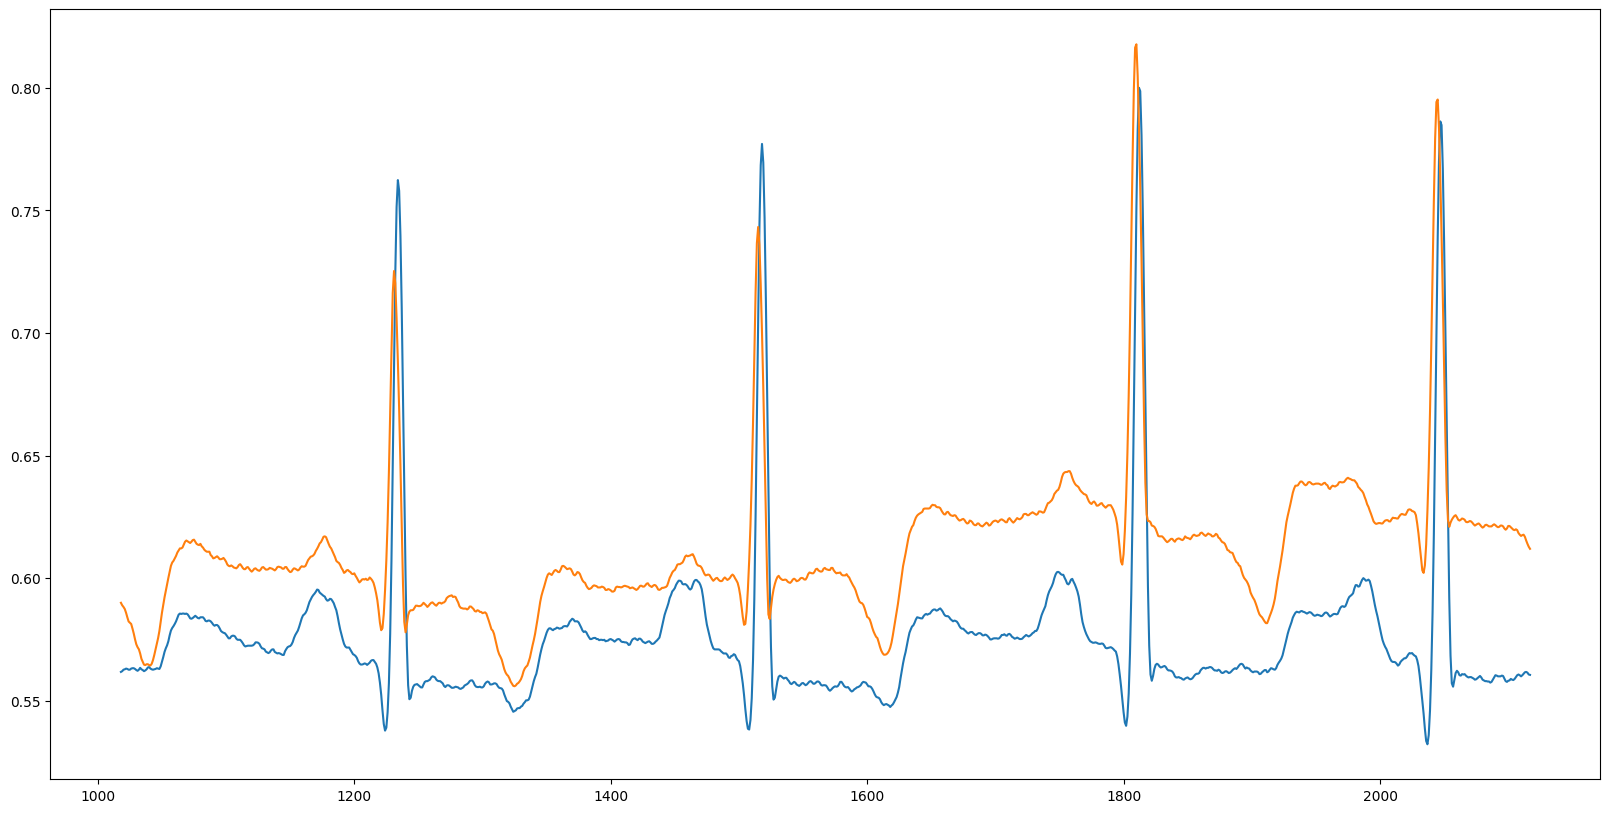

In [52]:
### Patient 100 example

# Reading ecg data
df_ecg = pd.read_csv('data/100.csv', quotechar="'")
df_ecg.rename(columns={'sample #':'Sample #'}, inplace=True)

# Reading annotations
df_annotations = pd.read_csv('data/100annotations.txt', sep='\s+')
df_annotations['Aux'] = df_annotations['Num'] 
df_annotations['Num'] = df_annotations['Chan']
df_annotations['Chan'] = df_annotations['Sub']
df_annotations['Sub'] = df_annotations['Type']
df_annotations['Type'] = df_annotations['#']
df_annotations.rename(columns={'Sample':'Sample #'}, inplace=True)
df_annotations.drop('#', axis=1, inplace=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on='Sample #', how='outer')



# Find the first row where AUX is not NaN
index_first_non_nan = df["Aux"].first_valid_index()
if index_first_non_nan is not None:
    df = df.loc[index_first_non_nan:]

# Scaling MLII and V5
scaler = MinMaxScaler()
MLII = df['MLII'].to_numpy()
V5 = df['V5'].to_numpy()
df['MLII'] = scaler.fit_transform(MLII.reshape(-1, 1))
df['V5'] = scaler.fit_transform(V5.reshape(-1, 1))

# Filtering MLII and V5 with moving average
df['MLII'] = df['MLII'].rolling(window=8, min_periods=1).mean()
df['V5'] = df['V5'].rolling(window=8, min_periods=1).mean()

df.reset_index(drop=True, inplace=True)

df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

# Plotting MLII and V5
plt.figure(figsize=(20, 10))
plt.plot(df['Sample #'][1000:2100], df['MLII'][1000:2100])
plt.plot(df['Sample #'][1000:2100], df['V5'][1000:2100])

beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list = []
std_list = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for index, row in beat_df.iterrows():
    sample1 = int(row['sample1'])
    sample2 = int(row['sample2'])
    # Calculate mean and std values for MLII
    mean_value = df['MLII'][sample1:sample2].mean()
    std = df['MLII'][sample1:sample2].std()
    mean_list.append(mean_value)
    std_list.append(std)

# Add a column to beat_df with the mean MLII and std values for each heartbeat
beat_df['MLII_mean'] = mean_list
beat_df['MLII_std'] = std_list

# All Patients Data Import

In [55]:
# Getting all filenames in data folder
folder_name = 'data'
folder_path = os.path.join(os.getcwd(), folder_name)
filenames = os.listdir(folder_path)

# Reading all ecg data
df_ecg = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), quotechar="'")
        df_temp.rename(columns={'sample #':'Sample #'}, inplace=True)
        df_temp.columns = df_temp.columns[:-2].tolist() + ['Signal 1', 'Signal 2']
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0]
        df_ecg = pd.concat([df_ecg, df_temp], axis=0, ignore_index=True)

# Reading all annotations
df_annotations = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.txt'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), sep='\s+', engine='python')
        df_temp['Aux'] = df_temp['Num'] 
        df_temp['Num'] = df_temp['Chan']
        df_temp['Chan'] = df_temp['Sub']
        df_temp['Sub'] = df_temp['Type']
        df_temp['Type'] = df_temp['#']
        df_temp.rename(columns={'Sample':'Sample #'}, inplace=True)
        df_temp.drop('#', axis=1, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0][0:3]
        df_annotations = pd.concat([df_annotations, df_temp], axis=0, ignore_index=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on=['Sample #', 'Patient'], how='outer')

# Create df_copy with only non-NaN values in Time column
df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

### Dataset truncation

In [56]:
# Create dataframe to truncate the data
filtered_data = pd.DataFrame()

# Iterate through each unique patient
for patient_id, group in df.groupby('Patient'):
    # Find the first row where AUX is not NaN
    index_first_non_nan = group['Aux'].first_valid_index()
    if index_first_non_nan is not None:
        filtered_data = pd.concat([filtered_data, group.loc[index_first_non_nan:]], ignore_index=True)

df = filtered_data

# Based on the time of the annotations, fill the NaN values with the previous annotation for the Type column
df['Type'] = df['Type'].fillna(method='ffill')

### Dataset information

Sample #    31197531
Signal 1    31197531
Signal 2    31197531
Patient     31197531
Time          112646
Type        31197531
Sub           112646
Chan          112646
Num           112646
Aux             1728
dtype: int64


<BarContainer object of 10 artists>

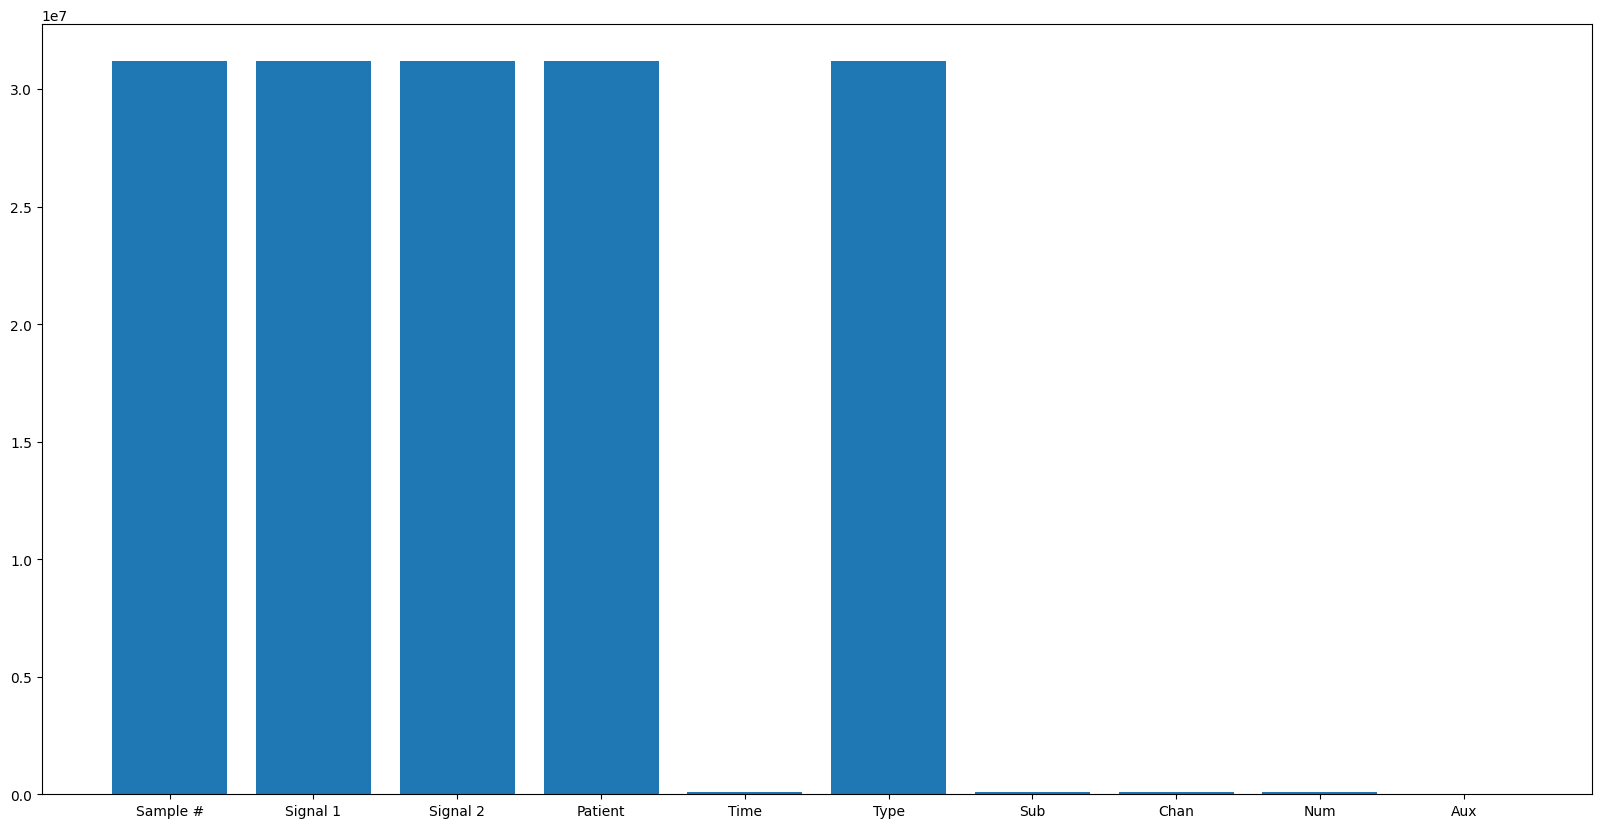

In [57]:
# For each feature count the number of non-null values
print(df.count())

# Plot each feature count in a bar plot
plt.figure(figsize=(20, 10))
plt.bar(df.columns, df.count())

In [58]:
# Print the types of each feature
print(df.dtypes)

Sample #      int64
Signal 1      int64
Signal 2      int64
Patient      object
Time         object
Type         object
Sub         float64
Chan        float64
Num         float64
Aux          object
dtype: object


In [59]:
df.describe()

,Sample #,Signal 1,Signal 2,Sub,Chan,Num
count,3.119753e+07,3.119753e+07,3.119753e+07,112646.000000,112646.0,112646.0
mean,3.250252e+05,9.562826e+02,1.001037e+03,0.062603,0.0,0.0
std,1.876240e+05,9.447422e+01,8.981329e+01,0.406945,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,0.0,0.0
25%,1.625380e+05,9.070000e+02,9.510000e+02,0.000000,0.0,0.0
50%,3.250250e+05,9.650000e+02,1.019000e+03,0.000000,0.0,0.0
75%,4.875120e+05,9.950000e+02,1.047000e+03,0.000000,0.0,0.0
max,6.499990e+05,2.047000e+03,2.047000e+03,9.000000,0.0,0.0


array([[<AxesSubplot: title={'center': 'Sample #'}>,
        <AxesSubplot: title={'center': 'Signal 1'}>],
       [<AxesSubplot: title={'center': 'Signal 2'}>,
        <AxesSubplot: title={'center': 'Sub'}>],
       [<AxesSubplot: title={'center': 'Chan'}>,
        <AxesSubplot: title={'center': 'Num'}>]], dtype=object)

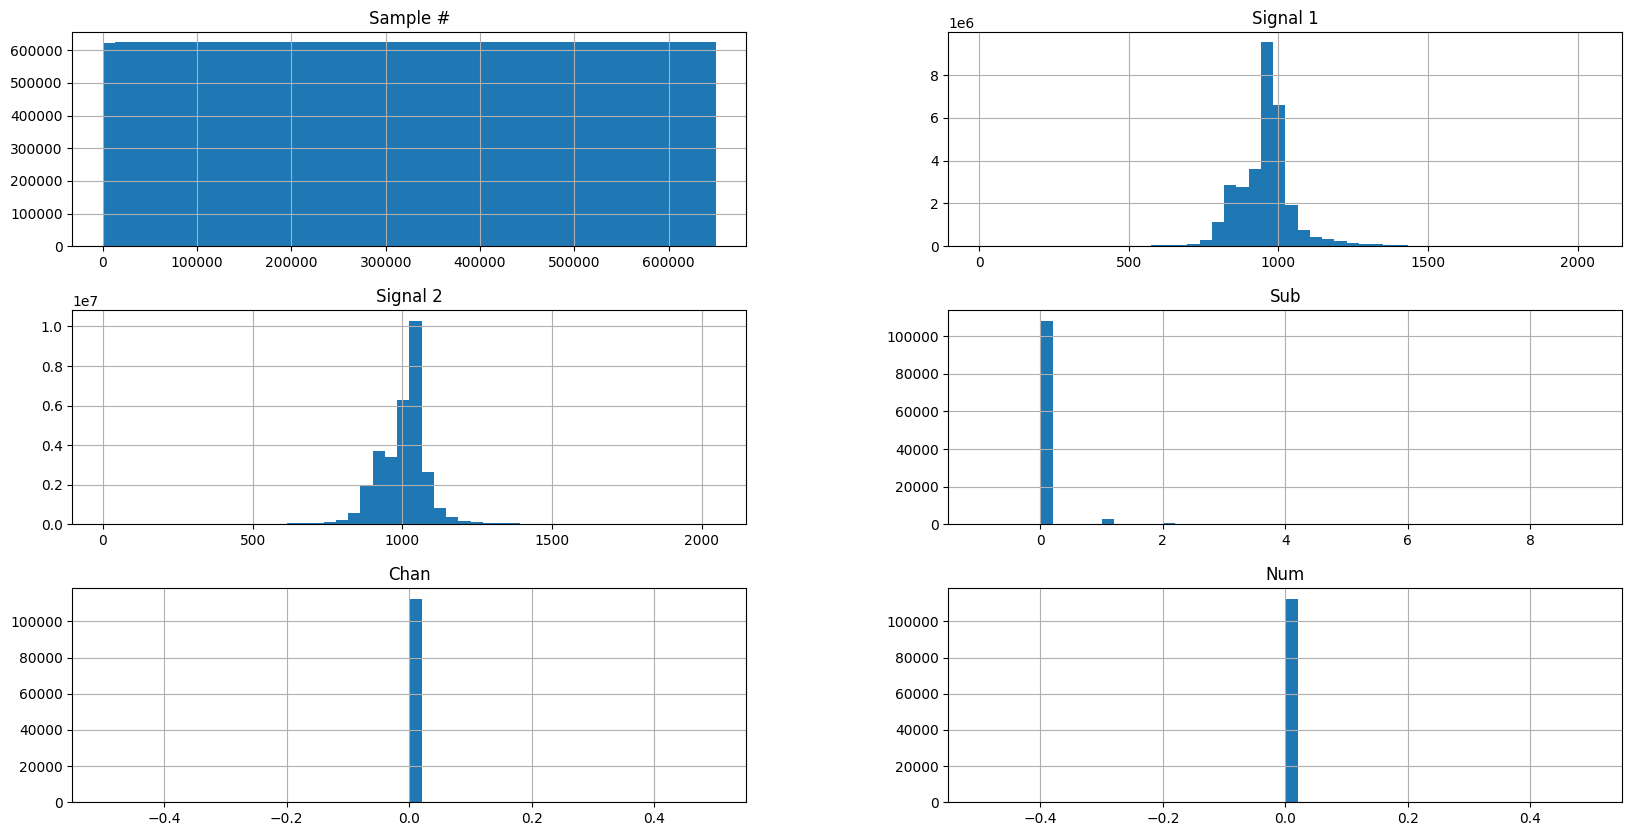

In [60]:
# Plot features histograms with the NaN values removed
df.hist(figsize=(20, 10), bins=50)

### Scaling signals

In [61]:
# Scaling signals
scaler = MinMaxScaler()
Signal1 = df['Signal 1'].to_numpy()
Signal2 = df['Signal 2'].to_numpy()

df['Signal 1'] = scaler.fit_transform(Signal1.reshape(-1, 1))
df['Signal 2'] = scaler.fit_transform(Signal2.reshape(-1, 1))

### Filtering signals

In [62]:
# Filtering signals
df['Signal 1'] = df['Signal 1'].rolling(window=8, min_periods=1).mean()
df['Signal 2'] = df['Signal 2'].rolling(window=8, min_periods=1).mean()

## beat_df dataframe

In [208]:
mean_list = []
std_list = []

beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list1 = []
std_list1 = []
mean_list2 = []
std_list2 = []
patient_list = []
type_list = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for patient_id in df['Patient'].unique():
    print(patient_id)
    for index, row in beat_df.loc[df_copy['Patient'] == patient_id].iterrows():

        sample1 = int(row['sample1'])
        sample2 = int(row['sample2'])

        # Calculate mean and std values for Signal 1
        mean_value = df['Signal 1'][sample1:sample2].mean()
        std = df['Signal 1'][sample1:sample2].std()
        mean_list1.append(mean_value)
        std_list1.append(std)

        # Calculate mean and std values for Signal 2
        mean_value = df['Signal 2'][sample1:sample2].mean()
        std = df['Signal 2'][sample1:sample2].std()
        mean_list2.append(mean_value)
        std_list2.append(std)

        patient_list.append(patient_id)
        type_list.append(df_copy['Type'][index])

# Add a column to beat_df with the mean MLII and std values for each heartbeat
beat_df['Signal 1 mean'] = mean_list1
beat_df['Signal 1 std'] = std_list1
beat_df['Signal 2 mean'] = mean_list2
beat_df['Signal 2 std'] = std_list2
beat_df['Patient'] = patient_list
beat_df['Type'] = type_list

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234


ValueError: cannot convert float NaN to integer

In [209]:
# print the last 5 rows of df_copy for patient 234
#print(beat_df.loc[df_copy['Patient'] == '234'].tail())

# print entries where RR interval < 0
print(beat_df.loc[beat_df['RR interval'] < 0])


         sample1  sample2  Heartbeat #  RR interval
2273    649991.0        7         2273 -1805.511111
4147    649751.0       68         4147 -1804.675000
6339    649852.0       21         6339 -1805.086111
8430    649875.0       36         8430 -1805.108333
10741   649876.0       67        10741 -1805.025000
13432   649740.0       83        13432 -1804.602778
15530   649791.0       47        15530 -1804.844444
17670   649748.0       23        17670 -1804.791667
19494   649769.0       18        19494 -1804.863889
22029   649931.0       31        22029 -1805.277778
24162   649724.0       15        24162 -1804.747222
26712   649883.0       22        26712 -1805.169444
28508   649994.0       21        28508 -1805.480556
30398   649783.0       44        30398 -1804.830556
32360   649955.0      174        32360 -1804.947222
34781   649957.0       72        34781 -1805.236111
36320   649926.0       13        36320 -1805.313889
38621   649742.0       32        38621 -1804.750000
40715   6497

### Classes grouping

In [163]:
# Group beats with 'Type' value of N, L, R, e and j into the N category
beat_df['Type'].replace(to_replace=['N', 'L', 'R', 'e', 'j'], value='N', inplace=True)

# Group beats with 'Type' value of A, a, J, S into the S category
beat_df['Type'].replace(to_replace=['A', 'a', 'J', 'S'], value='S', inplace=True)

# Group beats with 'Type' value of V, E into the V category
beat_df['Type'].replace(to_replace=['V', 'E'], value='V', inplace=True)

# Group beats with 'Type' value not above (except F) into the Q category
beat_df['Type'].replace(to_replace=['/', 'f', 'Q'], value='Q', inplace=True)

# Eliminate entries with ~, +, x, [, ], !, " and | in 'Type' column
beat_df = beat_df[beat_df['Type'] != '~']
beat_df = beat_df[beat_df['Type'] != '+']
beat_df = beat_df[beat_df['Type'] != 'x']
beat_df = beat_df[beat_df['Type'] != '[']
beat_df = beat_df[beat_df['Type'] != ']']
beat_df = beat_df[beat_df['Type'] != '!']
beat_df = beat_df[beat_df['Type'] != '"']
beat_df = beat_df[beat_df['Type'] != '|']

### Classes count

In [164]:
# Count how many times each Type value appears in the dataset
print(beat_df['Type'].value_counts())

N    90630
Q     8043
V     7236
S     2781
F      803
Name: Type, dtype: int64


## Undersampling

In [165]:
# Identify the majority class by finding the class with the most samples
majority_class = beat_df['Type'].value_counts().idxmax()

# Separate the majority and minority classes
majority_class_data = beat_df[beat_df['Type'] == majority_class]
minority_class_data = beat_df[beat_df['Type'] != majority_class]

# Determine the number of samples you want to keep for each minority class
# You can set this number based on the number of samples in the smallest minority class
undersampled_minority_class_size = minority_class_data['Type'].value_counts().min()

# Undersample each minority class
undersampled_minority_data = {}
for minority_class in minority_class_data['Type'].unique():
    undersampled_minority_data[minority_class] = minority_class_data.query(f'Type == "{minority_class}"').sample(n=undersampled_minority_class_size, random_state=42)

# Undersample the majority class
undersampled_majority_data = majority_class_data.sample(n=undersampled_minority_class_size, random_state=42)

# Combine the undersampled minority and majority classes
undersampled_data = pd.concat([undersampled_minority_data[minority_class] for minority_class in undersampled_minority_data], axis=0)
undersampled_data = undersampled_data.append(undersampled_majority_data, ignore_index=True)

# Check the counts for each class
print(undersampled_data['Type'].value_counts())

undersampled_data.hist(figsize=(20, 10))

# Print the number of entries in undersampled_data with RR interval > 5 and < 0
print(len(undersampled_data[(undersampled_data['RR interval'] > 5) | (undersampled_data['RR interval'] < 0)]))

# Delete entries with RR interval > 5 and < 0
undersampled_data = undersampled_data[(undersampled_data['RR interval'] <= 5) & (undersampled_data['RR interval'] >= 0)]

undersampled_data.head(20)

S    803
V    803
Q    803
F    803
N    803
Name: Type, dtype: int64


C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_21960\3802029230.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  undersampled_data = undersampled_data.append(undersampled_majority_data, ignore_index=True)


,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 2 mean,Signal 2 std,Patient,Type
0,110387,111069,105227,1.894444,0.471815,0.012890,0.482264,0.011086,232,S
1,276658,277031,94022,1.036111,0.473037,0.015592,0.488454,0.012800,222,S
2,57506,57768,105076,0.727778,0.469123,0.013411,0.480812,0.009719,232,S
3,380954,381191,71045,0.658333,0.474447,0.015975,0.486568,0.008945,210,S
4,36170,36407,66564,0.658333,0.470477,0.018908,0.481987,0.011727,209,S


## Neural Network Model

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
26/26 [==============================] - 0s 2ms/step
0.5828144458281445
[[149   4   1   5   1]
 [ 30  36  33  38  24]
 [  2   7 146   6   0]
 [ 32   7  13  87  22]
 [ 29  24  30  27  50]]
26/26 [==============================] - 0s 1ms/step
0.5765877957658779
[[139   8   0  11   2]
 [ 33  21  40  27  40]
 [  1   3 145   7   5]
 [ 22  11   9  99  20]
 [ 20  18  32  31  59]]
26/26 [==============================] - 0s 1ms/step
0.6014943960149439
[[146   7   1   6   1]
 [ 36  32  31  28  34]
 [  3   0 149   7   1]
 [ 20   8  10  95  27]
 [ 22  14  39  25  61]]
26/26 [==============================] - 0s 1ms/step
0.5810473815461347
[[138   8   2   7   6]
 [ 28  35  32  23  42]
 [  1   3 144   5   7]
 [ 26   7  19  85  23]
 [ 23  15  40  19  64]]
26/26 [==============================] - 0s 2ms/step
0.5922693266832918
[[140   7   3   7   4]
 [ 29  42  31  42  16]
 [  1  10 139  10   0]
 [ 26  10   7 102  15]
 [ 23  14  38  34  52]]
Mean Accuracy: 0.59
Standard 

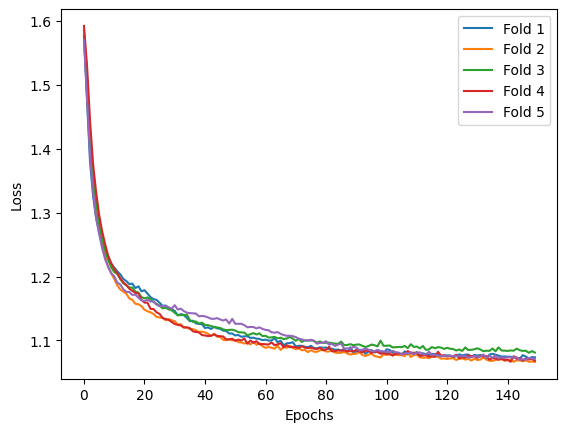

In [186]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

# Load your dataset (assuming you have it in a DataFrame)
# Replace 'target_column' with the actual name of your target variable column
# Replace other_column_names with the names of your input features
target_column = 'Type'
other_column_names = ['RR interval', 'Signal 1 mean', 'Signal 1 std', 'Signal 2 mean', 'Signal 2 std']

# Encode the target variable into numerical values
le = LabelEncoder()
undersampled_data[target_column] = le.fit_transform(undersampled_data[target_column])

# Print the encoding mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Define the number of cross-validation folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store cross-validation scores and histories
cv_scores = []
histories = []


# Define the architecture of the deep neural network
def create_model(input_dim, num_classes):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Iterate over the cross-validation folds
for train_index, test_index in skf.split(undersampled_data[other_column_names], undersampled_data[target_column]):
    X_train, X_test = undersampled_data[other_column_names].iloc[train_index], undersampled_data[other_column_names].iloc[test_index]
    y_train, y_test = undersampled_data[target_column].iloc[train_index], undersampled_data[target_column].iloc[test_index]

    # Create and compile the model
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    model = create_model(input_dim, num_classes)

    # Train the model and store the training history
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
    histories.append(history.history)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_pred)
    print(fold_accuracy)
    cv_scores.append(fold_accuracy)

    # Print confusion matrix for this fold
    print(confusion_matrix(y_test, y_pred))

# Calculate the mean and standard deviation of cross-validation scores
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation: {std_accuracy:.2f}")

# Plot the loss for each fold
for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i + 1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [149]:
# Print y_pred uniqur values
print(np.unique(y_pred))

# Count y_train
print(y_train.value_counts())

# Count y_test
print(y_test.value_counts())

# Count y_pred
print(pd.Series(y_pred).value_counts())

[0 1 2 3 4]
4    723
0    723
2    722
1    722
3    722
Name: Type, dtype: int64
1    81
4    80
0    80
3    80
2    80
Name: Type, dtype: int64
0    125
2     93
3     82
4     55
1     46
dtype: int64


In [185]:
# Print the second minimum and maximum values of RR interval
#print(beat_df['RR interval'].nsmallest(20))
#print(beat_df['RR interval'].nlargest(5))


# Print the entries with RR interval > 5 and < 0
print(beat_df[(beat_df['RR interval'] > 3)])

        sample1  sample2  Heartbeat #  RR interval  Signal 1 mean  \
105577   228928   230038       105577     3.083333       0.470061   
105586   232430   233542       105586     3.088889       0.474602   
105856   322580   323717       105856     3.158333       0.469622   
105912   342970   344483       105912     4.202778       0.465611   
105921   346792   347906       105921     3.094444       0.465757   
105935   352500   353976       105935     4.100000       0.462859   
105947   357060   358242       105947     3.283333       0.470830   
106005   378481   380595       106005     5.872222       0.472957   
106050   396468   398056       106050     4.411111       0.473272   
106078   407209   408462       106078     3.480556       0.470484   
106101   416130   417576       106101     4.016667       0.468538   
106132   427643   428804       106132     3.225000       0.471927   
106143   431658   432788       106143     3.138889       0.478740   
106178   444533   446025       106